This notebook preprocesses the IFS data to create input files for the firedanger tool written by Daniel Steinfeld. The preprocessing includes the selection of subregions, the time period, and variables and the interpolation from Healpix format to a lon-lat grid. Customization can be done in the first cell.

In [1]:
# %history -g -f history.txt

In [2]:
if __name__ == "__main__":

    # customize inputs

    exp_id = "IFS_9-FESOM_5-production"

    # time = "2D_hourly_healpix512_2020s"
    time = "2D_hourly_0.25deg"

    lon_min = 10.            # region to be selected (as lon/lat, use negative values for western/southern hemisphere)
    lon_max = 20.
    lat_min = 40.
    lat_max = 50.

    interpol_method="cubic"    # choose one out of nearest, linear, cubic 

    time_min = "2020-01-02"    # first date to be selected as YYYY-MM-DD (do not use 2020-01-01)
    time_max = "2020-03-01"    # last date to be selected as YYYY-MM-DD

    res_out_x = 2              # resolution of the interpolated files in degree lon
    res_out_y = res_out_x      # resolution of the interpolated files in degree lat

    dir_out = "/home/m/m300363/Next-GEMS/2024-10_Hackaton_Wageningen/"
    
    filename_out = dir_out + "test_IFS.nc"

In [3]:
    # !module use /work/k20200/k202134/hsm-tools/outtake/module; module load python3/hamburg-hackathon; python -m ipykernel install --name python-HH-hackathon --user

In [4]:
# import libraries

import sys
import objsize
import intake
import dask
from dask.diagnostics import ProgressBar
from multiprocessing import Pool, Manager, cpu_count, current_process
import pandas as pd
# import functools
import itertools
import gribscan
import eccodes
# import cmocean
import metpy.calc
from metpy import units, calc
# import healpy
import xarray as xr
import numpy as np
from scipy import interpolate
from datetime import datetime
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
# import logging
# from collections.abc import Iterable

In [5]:
# define functions

# def default_kwargs(**defaultKwargs):
#     def actual_decorator(fn):
#         @functools.wraps(fn)
#         def g(*args, **kwargs):
#             defaultKwargs.update(kwargs)
#             return fn(*args, **defaultKwargs)
#         return g
#     return actual_decorator

def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )
    
def compute_lhour(ds):
          
   lhour1 = 0 * ds.tp + ds.time.dt.hour + np.round(24/360*ds.lon)
   lhour2 = lhour1.where(lhour1>=0,lhour1+24)
   lhour3 = lhour2.where(lhour2<24,lhour2-24)
    
   return lhour3


# def compute_noonvals(ds,arrayname,varname):

#    # print("select noon values for ds: " + str(ds) + ", varname: " + varname +". output will be appended to " + arrayname)
   
#    lhour=compute_lhour(ds)
#    sel = np.where((lhour == 11) | (lhour == 12) | (lhour == 13),1,0)
#    # var_sel = eval("ds." + varname + "* sel")
#    var_sel = ds[varname] * sel
#    arrayname[varname] = var_sel.resample(time="D").sum()
    
#    return arrayname[varname]

def compute_noonvals(ds,varname):

    # print("select noon values for ds: " + str(ds) + ", varname: " + varname +". output will be appended to " + arrayname)
    
    lhour=compute_lhour(ds)
    sel = np.where((lhour == 11) | (lhour == 12) | (lhour == 13),1,0)
    # var_sel = eval("ds." + varname + "* sel")
    var_sel = ds[varname] * sel
    noonvals = var_sel.resample(time="D").sum()

    del lhour,sel,var_sel
    
    print("noonvals for ",varname, " computed on ", current_process(),flush=True)
    
    return varname, noonvals


# @default_kwargs(interpol_method="linear")
def interpolate_healpy2lonlat(input_array,output_array,varname,inlon,inlat,outlon,outlat,*args,**kwargs):
 
    print("interpolation method: ",interpol_method, flush=True)    
    
    outgrid=np.meshgrid(outlon,outlat)

    values_interpolated=np.empty((np.shape(input_array)[0],len(outlat),len(outlon)))

    i=0

    for date in input_array.time:
        values_tsel=input_array.sel(time=date) # .drop(time)
        values_interpolated[i][:][:] =  interpolate.griddata((inlon,inlat), values_tsel, (outgrid[0][:][:],outgrid[1][:][:]), method=interpol_method)
        i += 1

    output_array[varname] = values_interpolated

    del values_interpolated

    print("interpolation to lon-lat for ",varname, " computed on ", current_process(),flush=True)
    
    return output_array[varname]

In [6]:
if __name__ == "__main__":

    # load data

    cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
    experiment = cat.IFS[exp_id][time]

    # print(list(cat.IFS))
    # print()
    # print(list(cat.IFS[exp_id])) 

    ds = experiment(chunks="auto").to_dask().pipe(attach_coords)

    # [(x, ds[x].attrs.get("name")) for x in ds ]

/home/m/m300363/.conda/envs/hackaton_wageningen_2024/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [7]:
if __name__ == "__main__":

    # select region & pick (almost) noon-values for 3-hourly data

    # disclaimer: for time zones that do not have 12:00:00 values be relaxed by +/-1 hour

    ds.lon[ds.lon>180]=ds.lon[ds.lon>180]-360
    ds_reg=ds.sel(time=slice(time_min,time_max)).where((ds.lon > lon_min) & (ds.lon < lon_max) & (ds.lat > lat_min) & (ds.lat < lat_max),drop=True)

    del ds

In [8]:
if __name__ == "__main__":

    maxpoolsize = 6

    varlist = ['2t','2d','sp','tp','10u','10v']
    # varlist = ['2t','2d','sp','tp','10u']
    # varlist = ['2t','2d','sp','tp']

    poolsize = max(len(varlist),maxpoolsize)

    manager=Manager()
    noonvals=manager.dict()

In [9]:
# iterable = itertools.zip_longest(itertools.repeat(ds_reg,len(varlist)),itertools.repeat(noonvals,len(varlist)),varlist)

In [10]:
if __name__ == "__main__":
    
    # for var in varlist:
    #    compute_noonvals(ds_reg,noonvals,var)

    # with Pool(poolsize) as p:
   
    #    print(current_process())
    #    # p.starmap(compute_noonvals,iterable)

    def testfunc(a,b):
        out = "hippo, " + a + ", " + b + ", " + str(current_process()) 
        print("hippo",a,b,current_process())
        return b, out

    with Pool(poolsize) as pool:
        iterable = itertools.zip_longest(itertools.repeat(ds_reg,len(varlist)),varlist)
        # chunks = chunk(list_a, multiprocessing.cpu_count())    
        for instance in pool.starmap(compute_noonvals, [ step for step in iterable ],chunksize=4):
            output = instance
            noonvals[instance[0]] = instance[1]
            del output

noonvals for  2t  computed on  <ForkProcess name='ForkPoolWorker-2' parent=678936 started daemon>
noonvals for  10u  computed on  <ForkProcess name='ForkPoolWorker-3' parent=678936 started daemon>
noonvals for  2d  computed on  <ForkProcess name='ForkPoolWorker-2' parent=678936 started daemon>
noonvals for  10v  computed on  <ForkProcess name='ForkPoolWorker-3' parent=678936 started daemon>
noonvals for  sp  computed on  <ForkProcess name='ForkPoolWorker-2' parent=678936 started daemon>
noonvals for  tp  computed on  <ForkProcess name='ForkPoolWorker-2' parent=678936 started daemon>


In [13]:
# print(asizeof.asizeof(noonvals["2t"].values))
# print(sys.getsizeof(noonvals))
# objsize.get_deep_size(noonvals)

# help(objsize)

In [14]:
# objsize.get_deep_size(ds_reg)

In [15]:
if __name__ == "__main__":

    # compute wind speed from uas and vas

    uas_unit = units.units(ds_reg['10u'].attrs.get("units"))
    vas_unit = units.units(ds_reg['10v'].attrs.get("units"))
    pr_unit = units.units(ds_reg['tp'].attrs.get("units"))

    noonvals['wind_speed'] = calc.wind_speed(noonvals['10u'] * uas_unit ,noonvals['10v'] * vas_unit)

In [16]:
if __name__ == "__main__":

    # compute relative humidity from specific humidity

    dewpoint_unit = units.units(ds_reg['2d'].attrs.get("units"))
    tas_unit = units.units(ds_reg['2t'].attrs.get("units"))

    noonvals['hurs'] = calc.relative_humidity_from_dewpoint(noonvals['2t'] * tas_unit, noonvals['2d'] * dewpoint_unit)

In [17]:
if __name__ == "__main__":
    
    # interpolate data to lon-lat grid

    inlon = np.asarray(ds_reg.lon)
    inlat = np.asarray(ds_reg.lat)
    outlon = np.arange(lon_min,lon_max + res_out_x, res_out_x, dtype=float)
    outlat = np.arange(lat_min,lat_max + res_out_y, res_out_y, dtype=float)

    maxpoolsize = 6
    poolsize = max(len(varlist),maxpoolsize)

    varlist = ['2t','tp','10u','10v','wind_speed','hurs']

    manager=Manager()
    outvars_interpolated=manager.dict()

    # for var in varlist:
    #     interpolate_healpy2lonlat(noonvals[var],outvars_interpolated,var,inlon,inlat,outlon,outlat,print("interpol_method=" + interpol_method))

In [18]:
if __name__ == "__main__":

    with Pool(poolsize) as p:

        iterable = itertools.zip_longest(
            [ noonvals[var] for var in varlist ],
            itertools.repeat(outvars_interpolated,len(varlist)),
            [ var for var in varlist ],
            itertools.repeat(inlon,len(varlist)),
            itertools.repeat(inlat,len(varlist)),
            itertools.repeat(outlon,len(varlist)),
            itertools.repeat(outlat,len(varlist)),
            itertools.repeat(print("interpol_method=" + interpol_method),len(varlist))
          )

        # print(list(iterable))
    
        p.starmap(interpolate_healpy2lonlat,iterable,chunksize=4)

interpol_method=cubic
interpolation method:  cubic
interpolation method:  cubic
interpolation to lon-lat for  2t  computed on  <ForkProcess name='ForkPoolWorker-9' parent=678936 started daemon>
interpolation method:  cubic
interpolation to lon-lat for  tp  computed on  <ForkProcess name='ForkPoolWorker-9' parent=678936 started daemon>
interpolation method:  cubic
interpolation to lon-lat for  wind_speed  computed on  <ForkProcess name='ForkPoolWorker-10' parent=678936 started daemon>
interpolation method:  cubic
interpolation to lon-lat for  10u  computed on  <ForkProcess name='ForkPoolWorker-9' parent=678936 started daemon>
interpolation method:  cubic
interpolation to lon-lat for  hurs  computed on  <ForkProcess name='ForkPoolWorker-10' parent=678936 started daemon>
interpolation to lon-lat for  10v  computed on  <ForkProcess name='ForkPoolWorker-9' parent=678936 started daemon>


In [21]:
if __name__ == "__main__":

    dsout = xr.Dataset({
        "tas": (("time", "lat", "lon"), outvars_interpolated["2t"] - 273.15 , {"units": "degC"}),
        "wind_speed": (("time", "lat", "lon"), outvars_interpolated["wind_speed"], {"units": str(tas_unit)}),
        "uas": (("time", "lat", "lon"), outvars_interpolated["10u"], {"units": str(uas_unit)}),
        "vas": (("time", "lat", "lon"), outvars_interpolated["10v"], {"units": str(vas_unit)}),
        "pr": (("time", "lat", "lon"), outvars_interpolated["tp"], {"units": str(pr_unit)}),
        "hurs": (("time", "lat", "lon"), outvars_interpolated["hurs"], {"units": "1"})},
        coords={
        "time": [ datetime.strptime(np.datetime_as_string(x,unit="D") + "T12:00:00", "%Y-%m-%dT%H:%M:%S") for x in noonvals["2t"].time ], 
        "lat": ("lat", outlat, {"units": "degree_north"}),
        "lon": ("lon", outlon, {"units": "degree_east"}),
        },)

    dsout.to_netcdf(filename_out)

/home/m/m300363/.conda/envs/hackaton_wageningen_2024/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'cbar_label', 'scalefac'
  result = super().contourf(*args, **kwargs)


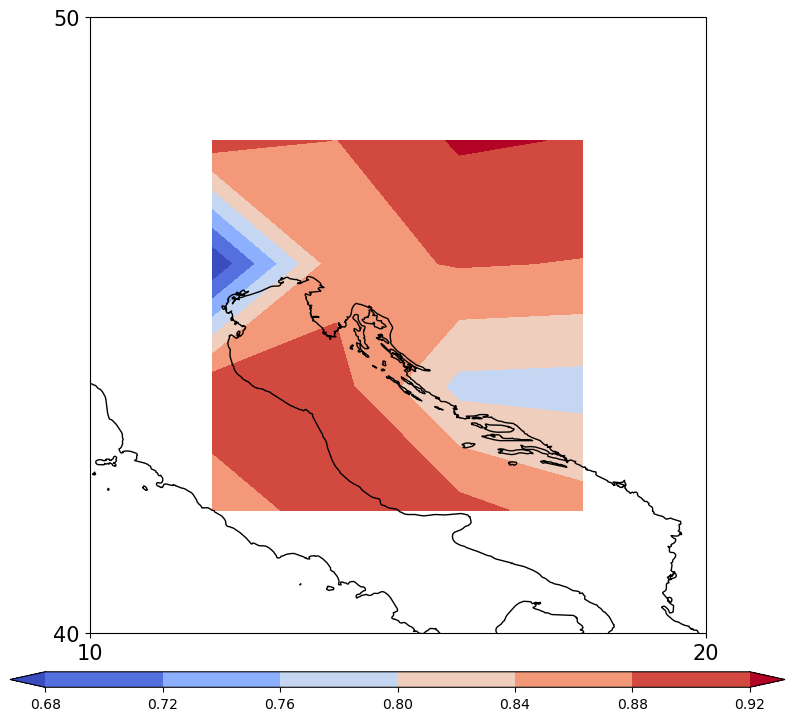

In [20]:
if __name__ == "__main__":

    plotval=dsout.hurs[1][:][:] # -273.15
    lon=dsout.lon
    lat=dsout.lat

    plot_args = {
        # "levels": (tuple(np.arange(-30,31,2))),
        "cmap": plt.cm.coolwarm,
        "extend": 'both',
        "cbar_label": 'degC',
        "scalefac": 1
        }

    #-- create figure and axes instances
    dpi = 100
    fig = plt.figure(figsize=(1000/dpi, 1000/dpi), dpi=dpi)

    min_lon = -180
    max_lon = 180
    min_lat = -80
    max_lat = 80

    proj=ccrs.PlateCarree()

    ax = plt.axes(projection=proj)
    # ax = plt.axes(projection=ccrs.AlbersEqualArea())
    # ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks(range(int(min_lon),int(max_lon)+30,10))
    ax.set_yticks(range(int(min_lat),int(max_lat)+30,10))
    ax.tick_params(axis="both",labelsize=15)
    # ax.set_extent([min_lon, max_lon, min_lat, max_lat]) # setting the borders of our map
   
    #-- draw coastlines, state and country boundaries, edge of map
    ax.add_feature(cfeature.COASTLINE)
    
    contourplot = ax.contourf(lon,lat,plot_args["scalefac"]*plotval,transform=proj,add_colorbar=False,**plot_args) # ,**cluster_plot_args,add_colorbar=False)
    cbar = plt.colorbar(contourplot,orientation='horizontal',pad=0.05,aspect=50,ax=ax)